In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

In [43]:
def wrangle(filepath):
    # Import CSV
    df = pd.read_csv(filepath)
    # Drop columns
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    # feature creation
    df['Family'] = df['SibSp'] + df['Parch']
    # Drop columns
    df = df.drop(columns=['SibSp', 'Parch'])
    # Create an imputer object with a strategy to fill missing values with the median
    imputer = SimpleImputer(strategy='median')
    df['Age'] = imputer.fit_transform(df[['Age']])
    return df
    

In [44]:
train_data = wrangle("titanic_data/train.csv")
train_data.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Family
0,693,3,male,28.5,56.4958,S,1,0
1,482,2,male,28.5,0.0000,S,0,0
2,528,1,male,28.5,221.7792,S,0,0
3,856,3,female,18.0,9.3500,S,1,1
4,802,2,female,31.0,26.2500,S,1,2
5,653,3,male,21.0,8.4333,S,0,0
6,510,3,male,26.0,56.4958,S,1,0
7,558,1,male,28.5,227.5250,C,0,0
8,829,3,male,28.5,7.7500,Q,1,0
9,19,3,female,31.0,18.0000,S,0,1


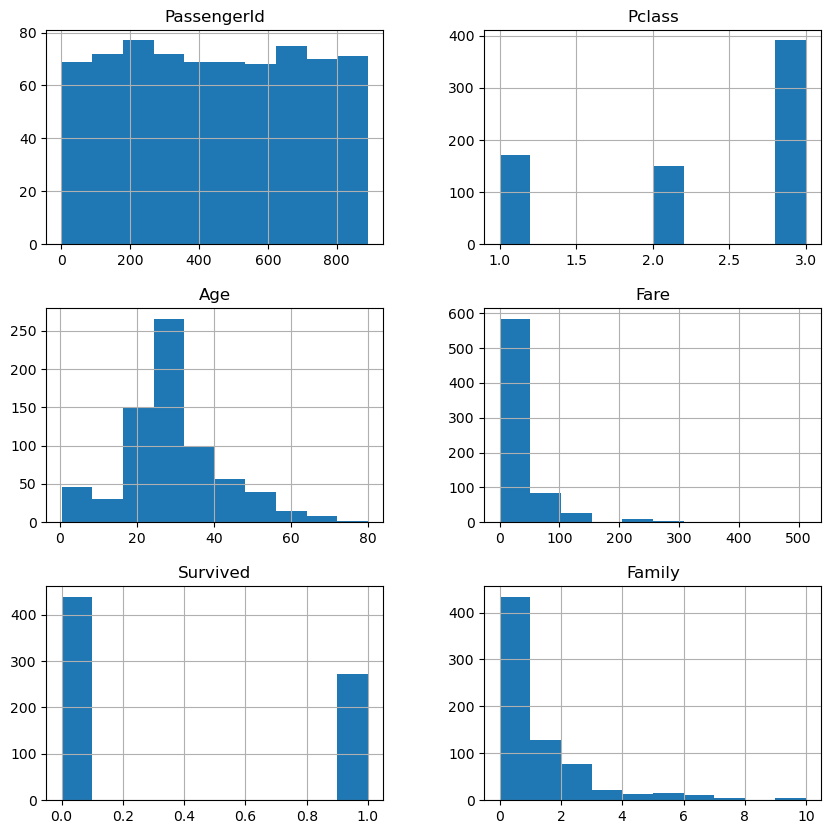

In [45]:
train_data.hist(figsize=(10,10));

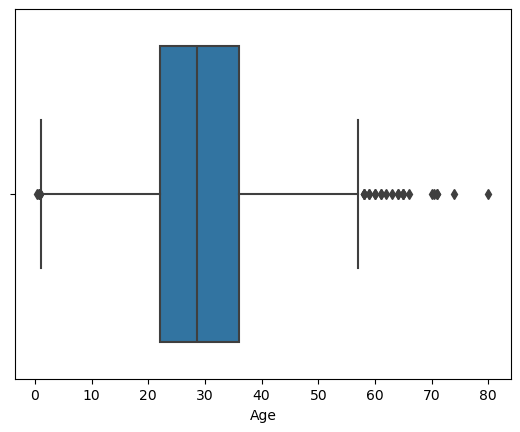

In [46]:
sns.boxplot(x='Age', data=train_data);

In [47]:
le = LabelEncoder()

In [48]:
for col in train_data.select_dtypes('object'):
    train_data[col] = le.fit_transform(train_data[col])

In [49]:
# Apply log transformation to fix skewness in the 'Fare' column
train_data['Fare'] = np.log1p(train_data['Fare'])


In [50]:
# Display the first few rows to verify the transformation
train_data.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Family
0,693,3,1,28.5,4.051712,2,1,0
1,482,2,1,28.5,0.000000,2,0,0
2,528,1,1,28.5,5.406181,2,0,0
3,856,3,0,18.0,2.336987,2,1,1
4,802,2,0,31.0,3.305054,2,1,2


In [51]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_data['Age'].quantile(0.25)
Q3 = train_data['Age'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
train_data = train_data[(train_data['Age'] >= lower_bound) & (train_data['Age'] <= upper_bound)]

# Display the first few rows to verify the changes
train_data.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Family
0,693,3,1,28.5,4.051712,2,1,0
1,482,2,1,28.5,0.000000,2,0,0
2,528,1,1,28.5,5.406181,2,0,0
3,856,3,0,18.0,2.336987,2,1,1
4,802,2,0,31.0,3.305054,2,1,2


In [52]:
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [54]:
scaler = StandardScaler()

In [55]:
X_train = scaler.fit_transform(X_train)

In [68]:
# Create a pipeline with an imputer, scaler, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])


In [69]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [70]:
# Evaluate the pipeline on the test data
pipeline.score(X_test, y_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


0.5693430656934306

Change the model 
Most are AI generated so redo it again 
Add markdown and comments too